#Massive parallel corpora extractor

##Intro

This is a notebook for extracting parallel corpora from two texts using Google Colab backend for increasing the processing speed. Model was fine-tuned for Russian-Udmurt language pairs, therefore quality for other languages may be affected. Use the vanilla LaBSE model for other language pairs.

Alignment and conflicts resolving logic is incapsulated in lingtrain_alignment package. UI version of the project known as [Lingtrain Alignment Studio](https://github.com/averkij/a-studio) and can be used for the corpora editing and parallel books creating.

Sentense transtormers project:

- https://sbert.net
- https://github.com/UKPLab/sentence-transformers

Lingtrain Aligner project:

- https://github.com/averkij/lingtrain-aligner
- https://github.com/averkij/a-studio
- https://t.me/lingtrain_books

--

_Sergei Averkiev_ @averkij

## Check the card

To use the GPU be sure that it is selected in the 'Runtime / Change runtime type' menu.

Colab pro subscription will give you better device, but free version is also OK.

<img src="https://i.imgur.com/FsK4Tvg.png" width="600">

In [ ]:
!nvidia-smi

Tue Mar 18 13:06:24 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   57C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Setup

In [ ]:
#@title Install dependencies

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
from IPython.utils import io
import torch
import time
from torch import optim
from torch.nn import functional as F
import shutil
import pickle
import os
import re

with io.capture_output() as captured:
  !pip install transformers sentencepiece sentence_transformers xmltodict pypinyin pykakasi

from sentence_transformers import SentenceTransformer, SentencesDataset, LoggingHandler, losses
from sentence_transformers.readers import InputExample
from sentence_transformers.evaluation import SentenceEvaluator
from torch.utils.data import DataLoader
from datetime import datetime
import math

from transformers import AdamW, AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from tqdm.notebook import tqdm

with io.capture_output() as captured:
  !pip install lingtrain_aligner==1.0.2 dateparser razdel

from lingtrain_aligner import preprocessor, splitter, aligner, resolver, reader, helper, vis_helper, metrics

sns.set()

In [ ]:
#@title Choose the model
model_name = "LaBSE (Russian-Udmurt fine-tuned)" #@param ["LaBSE", "LaBSE (Russian-Udmurt fine-tuned)", "Sentence Transformers DistilUSE multilingual v2"]

model_names = {
    "LaBSE": 'labse',
    "LaBSE (Russian-Udmurt fine-tuned)": 'labse_ru_udm',
    "Sentence Transformers DistilUSE multilingual v2": 'st2'
    }

if model_names[model_name] == 'labse_ru_udm':
  model = SentenceTransformer('lingtrain/labse-udmurt')
elif model_names[model_name] == 'st2':
  model = SentenceTransformer('distiluse-base-multilingual-cased-v2')
else:
  model = SentenceTransformer('LaBSE')




/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/205 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/14.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/860 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/5.22M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/13.6M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

##Texts to align

Expand the section and paste your text into the text1 and text2 variables.

In [ ]:
#@title First text

text1 = """ЛЬӦЛЬ СЯСЬКА%%%%%title.
Кемалась ни вылэм со. Одӥг пичигес гинэ удмурт гуртын улэм пересь воргорон. Солэн вылэм чиед гинэ Ондӥ нимо пиез. Аръёс ортчемъя, пересь доры матэктыны кутскем кулон но. Соку со пизэ дораз ӧтем но тазьы верам:— Шудо луэмед ке потэ, котькинлы тыршы умой уж лэсьтыны. Ӟечсэ уз вунэтэ.Мукет номыр верамтэ ни со. Кӧня ке нунал ортчыса люкиськем югыт дуннеен, нош Ондӥлы огназлы мӧзмыт потэм — дасяськем сюрес вылэ.Мынэ, пе, со шур кузя но ас понназ кырӟа:— Шулдыр вордскем палъёсы,Но мӧзмыт мыным.Оло, шуд шедьто аслымМукет шаерын.Кырӟамзэ кылэм пересь кышномурт.— Валасько, пие,— шуген вамышъяса лыктонъяз, пе, шуэ со,— сюлэмад секыт кайгу вань. Ма бен луиз тонэн сыӵе?— Атае кулӥз мынам, пересь, нош мон огнам кыли. Табере, тани, потӥ аслэсьтым шудме утчаны.- Бен, кайгуэд пичи вылымтэ, но тон мыным боды лэсьтыса уд сёты-а, чик ӟигары уг тырмы ни.Ондӥлэн тодаз лыктэм атаезлэн верам кылыз: «...Котькинлы тыршы умой уж лэсьтыны». Бадяр ваез чигем но пересьлы боды лэсьтэм. Соиз пилы возьматэм сюрес, кудӥз сое шудэз доры вуттоз.Вамыштэм Ондӥ азьлань. Мынэ, мынэ, пе, но — шӧдтэк шорысь кышкыт кесяськем кылэм. Учке но: Луд Кеч кык пыд йылаз сылэ, адями куараен, пе, вазиське:— Юртты мыным, егит пи, ватскыны. Ӝоген татчы сьӧд кышномурт, Нюлэс Ош, лыктоз. Со монэ виыны турттэ.Озьы вераса вуттэм гинэ — кызъёс сьӧрысь адскем кышкыт пересь кышно — ымнырыз сьӧд, пиньёсыз кузесь, нош синъёсыз писэйлэн кадь, пе, ӝуало. Кема жугиськоно луэм таин Ондӥ. Озьы ке но, вормем. Луд Кеч солы тау карем но сюрес возьматэм.Вуэм Ондӥ ошмес дуре. Куара, пе, кылэ:— Ӝут, Ондӥ, мон вӧзысь изэз, мыным потыны секыт.Басьтэм со ошмес вӧзысь изэз. Отчы соку ик льӧль сяська кылдэм. Пияш мыкырскем со доры но маялтэм. Соку ик со азе, пе, чебер ныл кылдэм — сыӵе чебер, кыӵезэ Ондӥ ноку но адӟылымтэ на.— Монэ вегин кышно тазьы кариз — сяськалы пӧрмытӥз но изэн ӵоксаз. Тау тыныд, Ондӥ, мозмытӥд тон монэ,— шуэм со.Пи синмаськем солы. Озьы соос ӵош улыны кутскиллям, выль корка пуктӥллям. Нош укно дуразы, пе,— котькуд гужем но тулыс ӝужась льӧль сяська. Та семьялэсь шудо но тупаса улэмзэ возьматыса будэ со.
"""

text1 = re.sub(r'([!?\.:,])(?!\.)', r'\1 ', text1)
text1 = re.sub('\s+', ' ', text1)

In [ ]:
#@title Second text

text2 = """АЛЫЙ ЦВЕТОК
Давным-давно это было. В одной маленькой удмуртской деревне жил старик. Был у него сын по имени Андрей. Чувствуя приближение смерти, позвал старик его к себе и сказал:— Если хочешь быть счастливым, сынок, старайся всем помогать. Хорошее людьми не забывается.И больше ничего не сказал, а через несколько дней умер.Андрей погоревал, погоревал, собрался в дорогу и пошёл по свету счастье искать.Идёт он вдоль реки и песенку поёт:Красивы родные места,Но грустно мне.Может, счастье найду себеВ чужих краях.Услышала его песню старушка.— Понимаю тебя, сынок, — говорит она, — на сердце у тебя тяжёлое горе есть. Что с тобой такое случилось?— Отец мой умер, бабушка, один я остался. Вот пошёл своё счастье искать.— Да, горе твоё немаленькое. Сделай-ка доброе дело, смастери мнеклюку. Видишь, ходить без поддержки трудно.Вспомнил Андрей отцовские слова: «...старайся всем помогать». Отломил он кленовую ветку и сделал из неё старушке клюку. А та за это показала ему дорогу, которая к счастью приведёт.Пошагал Андрей вперёд. Идёт, идёт, вдруг слышит страшный крик. Смотрит: Заяц на двух лапах стоит. И тут Заяц человеческим голосом ему говорит:— Помоги мне, парень, спрятаться. Скоро придут сюда ведьма с лесным быком. Они хотят погубить меня.Только успел сказать, как из-за елей показалась страшная ведьма— лицо чёрное, зубы длинные, глаза, как у кошки, горят. Долго она боролась с Андреем. Но парень её одолел. Заяц поблагодарил своего спасителя и показал дорогу.Пришёл Андрей к роднику. Вдруг слышит чей-то голос. Оглянулся, а это родник говорит:— Подними, Андрей, с меня камень. Тяжело мне!Убрал он с родника камень, а из него алый цветок вырос. Парень наклонился и погладил его, и тут же перед ним красивая девушка появилась. Да такой красоты, какой Андрей никогда ещё не видал.—Ведьма меня в цветок превратила и под камнем спрятала. Спасибо тебе, Андрей, за то, что освободил меня, — с поклоном сказала девушка.Андрей сразу влюбился в прекрасную девушку. И она его полюбила. Стали они вместе жить, новый дом построили. А на подоконнике их дома каждое лето и весну расцветал алый цветок, как символ их мирной и счастливой жизни.
"""

text2 = re.sub(r'([!?\.:,])(?!\.)', r'\1 ', text2)
text2 = re.sub('\s+', ' ', text2)

In [ ]:
#@title Prepare texts for alignment and create the alignment database
import os

lang_from = "udm"
lang_to = "ru"
db_path = "alignment.db"

use_proxy_from = False
use_proxy_to = False

splitted_from = splitter.split_by_sentences(text1.split('\n'), lang_from)
splitted_to = splitter.split_by_sentences(text2.split('\n'), lang_to)

print(f"First 10 sentences of {lang_from} text ({len(splitted_from)} in total):\n")
for i,x in enumerate(splitted_from[:10]):
  print(i+1,x)

print(f"\n\nFirst 10 sentences of {lang_to} text ({len(splitted_to)} in total):\n")
for i,x in enumerate(splitted_to[:10]):
  print(i+1,x)

if os.path.isfile(db_path):
    os.unlink(db_path)

aligner.fill_db(db_path, lang_from, lang_to, splitted_from, splitted_to)

print(f"\n{db_path} created")

First 10 sentences of udm text (42 in total):

1 ЛЬӦЛЬ СЯСЬКА%%%%%title.
2 Кемалась ни вылэм со.
3 Одӥг пичигес гинэ удмурт гуртын улэм пересь воргорон.
4 Солэн вылэм чиед гинэ Ондӥ нимо пиез.
5 Аръёс ортчемъя, пересь доры матэктыны кутскем кулон но.
6 Соку со пизэ дораз ӧтем но тазьы верам: — Шудо луэмед ке потэ, котькинлы тыршы умой уж лэсьтыны.
7 Ӟечсэ уз вунэтэ.
8 Мукет номыр верамтэ ни со.
9 Кӧня ке нунал ортчыса люкиськем югыт дуннеен, нош Ондӥлы огназлы мӧзмыт потэм — дасяськем сюрес вылэ.
10 Мынэ, пе, со шур кузя но ас понназ кырӟа: — Шулдыр вордскем палъёсы, Но мӧзмыт мыным.


First 10 sentences of ru text (43 in total):

1 АЛЫЙ ЦВЕТОК Давным-давно это было.
2 В одной маленькой удмуртской деревне жил старик.
3 Был у него сын по имени Андрей.
4 Чувствуя приближение смерти, позвал старик его к себе и сказал: — Если хочешь быть счастливым, сынок, старайся всем помогать.
5 Хорошее людьми не забывается.
6 И больше ничего не сказал, а через несколько дней умер.
7 Андрей погоревал, п

## [Optional] Align through proxy text


### Download splitted text

Get the splitted text on the language that you want to translate.

In [ ]:
from lingtrain_aligner import aligner

lines_from = aligner.get_splitted_from(db_path)
lines_to = aligner.get_splitted_to(db_path)

with open("splitted_from.txt", mode="w", encoding="utf-8") as output:
  for line in lines_from:
    output.write(line + "\n")

with open("splitted_to.txt", mode="w", encoding="utf-8") as output:
  for line in lines_to:
    output.write(line + "\n")

### Translate the splitted text and upload it to this environment

You can use the following Colab notebook for translating the splitted text throught the Bing API:

https://colab.research.google.com/drive/10bZdtwwX3g8SQDlEaodVn0pXVLWYj_JD

<img src="https://i.imgur.com/DzYjOHv.png" width="300px">

### Add proxy text to the alignment

Choose the appropriate direction. 'From' for the first text or 'to' for the second text.

In [ ]:
aligner.load_proxy(db_path, '/content/text_proxy.txt', direction="from")

In [ ]:
use_proxy_from = True
use_proxy_to = False

##Align texts

The main parameters here are **batch_ids**, **shift** and **window**.

###batch_ids

Using this parameter you can select which part of text you want to align. batch_ids=[0,1] will align first two batches. batch_ids=[] will align the whole texts. Default batch size = 200.

###shift and window

Normally alignment looks like this:

<img src="https://i.imgur.com/wwadfSi.png" width="400px">

The diagonal line sholud be traced on the visualization. If on some batch it's starting to look like this:

<img src="https://i.imgur.com/ESiz057.png" width="400px">

try to play with shift parameter (e.g shift=-40 or shift=40) **on this batch**. This will shift the flow of a second text relative to the first one.



In [ ]:
batch_ids = [0,1,2,3]

shift = 0
window = 50

Aligning without segments.
tasks amount: 1
batch: 0 (0)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/9 [00:00<?, ?it/s]


--- 0.35703325271606445 seconds ---


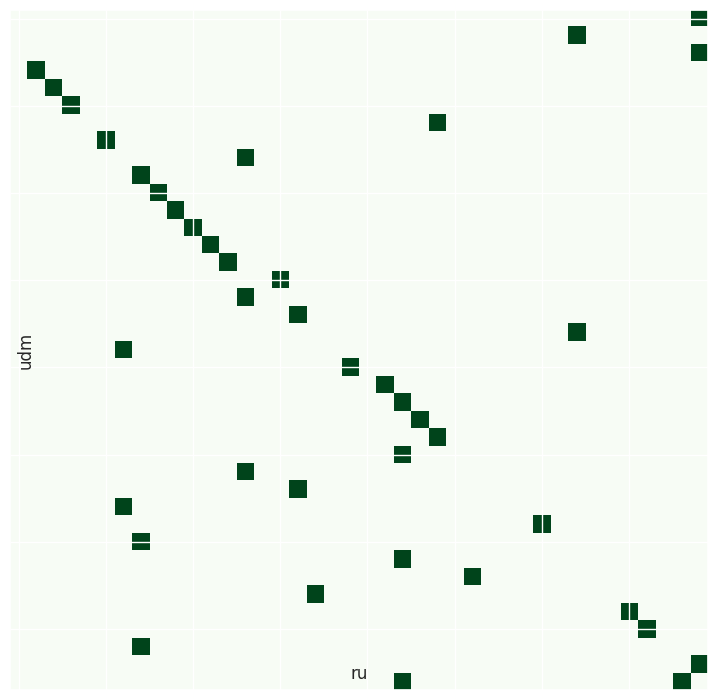


  score: 0.275


In [ ]:
#@title Align and visualize

import time
start_time = time.time()

aligner.align_db(db_path,
                model_name="sentence_transformer_multilingual_labse",
                batch_size=200,
                window=window,
                batch_ids=batch_ids,
                save_pic=False,
                embed_batch_size=5,
                normalize_embeddings=True,
                show_progress_bar=True,
                shift=shift,
                model=model,
                use_proxy_from=use_proxy_from,
                use_proxy_to=use_proxy_to
                )

print("\n--- %s seconds ---" % (time.time() - start_time))

vis_helper.visualize_alignment_by_db(db_path,
            output_path="alignment_vis.png",
            batch_size=800,
            size=(900,900),
            lang_name_from=lang_from,
            lang_name_to=lang_to,
            batch_ids=batch_ids,
            plt_show=True,
            show_info=False)

print("\n  score:", metrics.chain_score(db_path))
# print("score 2:", metrics.chain_score(db_path, mode="both"))

##Resolve conflicts

After you see the diagonal line on all the batches you can align the outliers by resolving the conflicts. **max_conflicts_len** parameter controls the maximum conflicts length. Too wide conflicts may cause too large amount of resolving variants and the process may stuck. So the very large conflicts will not be resolved. If needed you can resolve them in the Lingtrain Alignment Studio.

conflicts to solve: 3
total conflicts: 5
('5:5', 2)
('5:4', 1)
('8:10', 1)
('11:12', 1)


100%|██████████| 3/3 [00:00<00:00, 14.64it/s]


--------------------------------
resolved. step 1 


score: 0.575


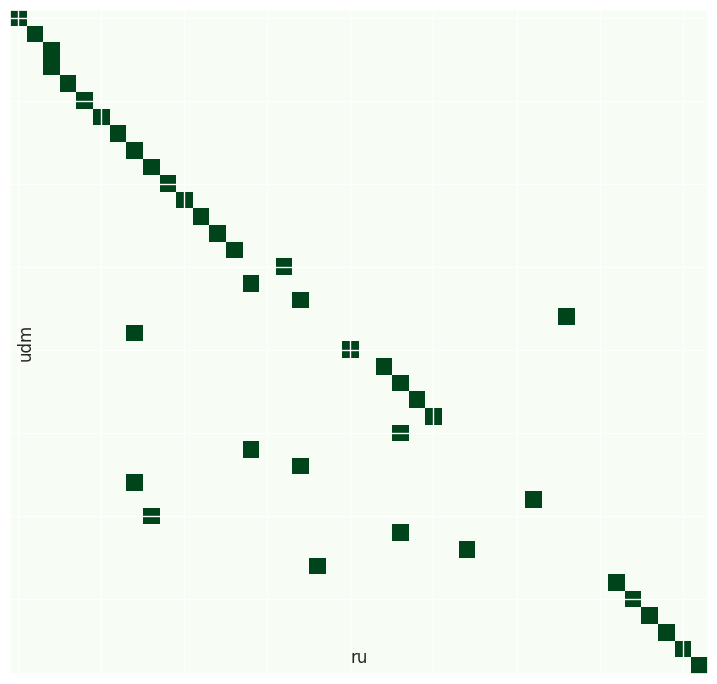

conflicts to solve: 2
total conflicts: 2
('8:10', 1)
('11:12', 1)


100%|██████████| 2/2 [00:00<00:00,  5.16it/s]


--------------------------------
resolved. step 2 


score: 1.0


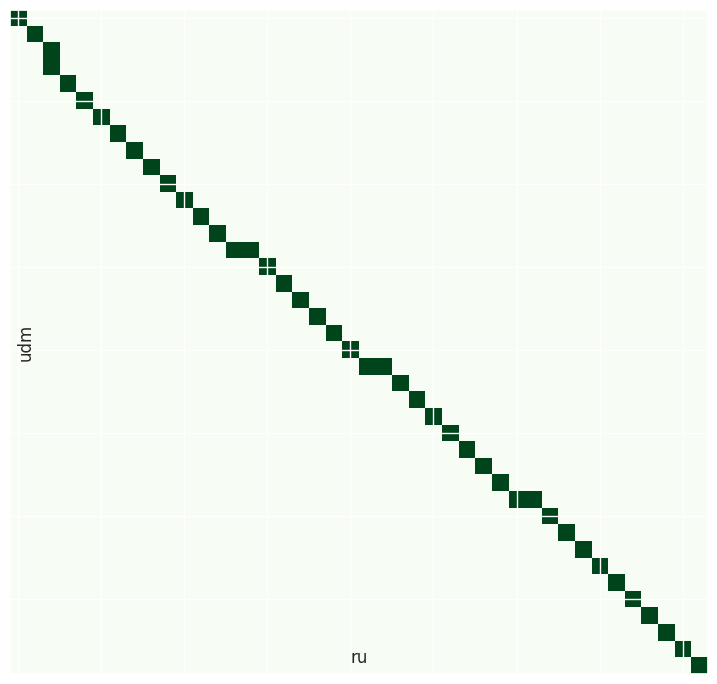

conflicts to solve: 0
total conflicts: 0


0it [00:00, ?it/s]


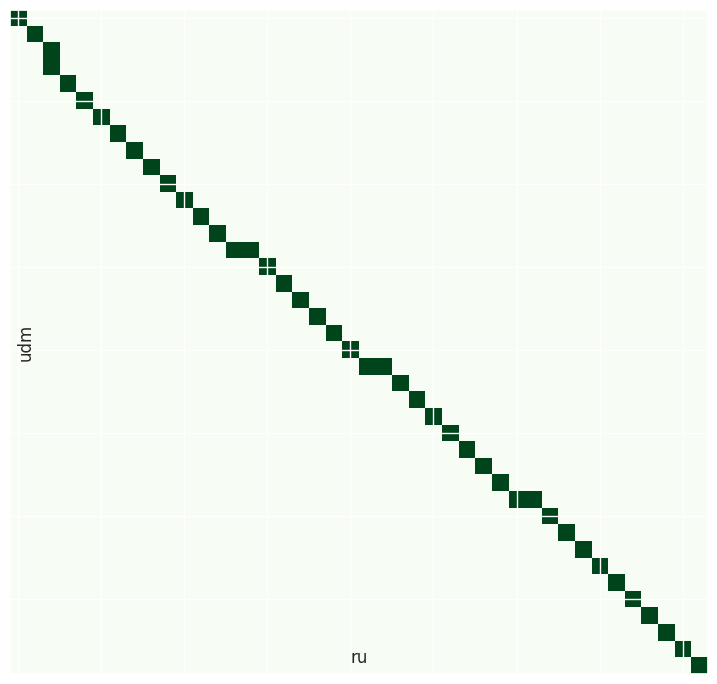


  score: 1.0
calculated --- 1.4487717151641846 seconds ---


In [ ]:
import time
start_time = time.time()

steps = 3
batch_id = -1
for i in range(steps):
    conflicts, rest = resolver.get_all_conflicts(db_path,
                                                 min_chain_length=2+i,
                                                 max_conflicts_len=6*(i+1),
                                                 batch_id=batch_id,
                                                 handle_start=True,
                                                 handle_finish=True,)
    resolver.get_statistics(conflicts)
    resolver.get_statistics(rest)

    resolver.resolve_all_conflicts(db_path, conflicts, model_name, show_logs=False, model=model)

    print("--------------------------------\nresolved. step", i+1, "\n\n")
    print("score:", metrics.chain_score(db_path))
    # print("score 2:", metrics.chain_score(db_path, mode="both"),"\n------------------------------")

    vis_helper.visualize_alignment_by_db(db_path,
            output_path="alignment_vis.png",
            batch_size=800,
            size=(900,900),
            lang_name_from=lang_from,
            lang_name_to=lang_to,
            # batch_ids=batch_ids,
            plt_show=True)

    if len(rest) == 0:
        break

conflicts, rest = resolver.get_all_conflicts(db_path,
                                             min_chain_length=2,
                                             max_conflicts_len=26,
                                             batch_id=batch_id,
                                             handle_start=True,
                                             handle_finish=True,)
resolver.get_statistics(conflicts)
resolver.get_statistics(rest)

resolver.resolve_all_conflicts(db_path, conflicts, model_name, show_logs=False, model=model)

vis_helper.visualize_alignment_by_db(db_path,
            output_path="alignment_vis.png",
            batch_size=800,
            size=(900,900),
            lang_name_from=lang_from,
            lang_name_to=lang_to,
            # batch_ids=batch_ids,
            plt_show=True)

print("\n  score:", metrics.chain_score(db_path))
print("calculated --- %s seconds ---" % (time.time() - start_time))

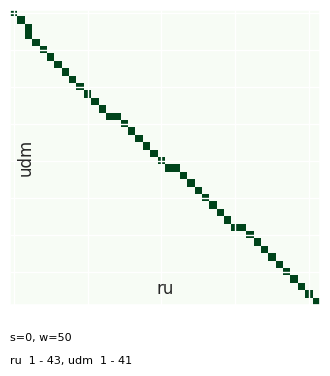

In [ ]:
#@title Visualize all batches

vis_helper.visualize_alignment_by_db(db_path,
            output_path="alignment_vis.png",
            batch_size=200,
            size=(400,400),
            lang_name_from=lang_from,
            lang_name_to=lang_to,
            # batch_ids=batch_ids,
            plt_show=True,
            show_info=True)

## Export the corpora

Choose the needed batches in batch_ids parameter. batch_ids=[] will select all the batches.



In [ ]:
from lingtrain_aligner import saver

batch_ids=[]

output_path="/content"

saver.save_plain_text(db_path, os.path.join(output_path, f"corpora_{lang_from}.txt"), side="from", batch_ids=batch_ids)
saver.save_plain_text(db_path, os.path.join(output_path, f"corpora_{lang_to}.txt"), side="to", batch_ids=batch_ids)

saver.save_tmx(db_path, os.path.join(output_path, f"corpora_{lang_from}_{lang_to}.tmx"), lang_from, lang_to)

print("Saved to ", f"corpora_{lang_from}.txt", f"corpora_{lang_to}.txt")

Saved to  corpora_udm.txt corpora_ru.txt


After executing the previous cell you can find the corpora in the files section.

<img src="https://i.imgur.com/rAi8N8d.png" width="300">

For detailes of the processing algorithms please refer to the following resources:

- https://github.com/averkij/a-studio
- https://habr.com/ru/articles/791188/
- https://habr.com/ru/articles/704958/
- https://habr.com/ru/articles/564944/




In [ ]:
import transformers, sentence_transformers

print("torch", torch.__version__)
print("transformers", transformers.__version__)
print("sentence_transformers", sentence_transformers.__version__)

torch 2.6.0+cu124
transformers 4.48.3
sentence_transformers 3.4.1


In [ ]:
#debug
#gradient_checkpointing attribute fix

# model.save('/content/last_model_ba')
# model = SentenceTransformer('/content/last_model_ba')

# import pickle

# with open('/content/drive/MyDrive/best_model_ba.bin', 'wb') as output_file:
#    pickle.dump(model, output_file)

## Calculate sentence pairs similarity

With similarity coefficients you can take the most confident pairs above some threshold.

In [ ]:
from lingtrain_aligner import helper, aligner

lines_from, lines_to = helper.read_processing(db_path)

print(len(lines_from), len(lines_to))

40 40


In [ ]:
vec_from = aligner.get_line_vectors(lines_from, model_name="", model=model)
vec_to = aligner.get_line_vectors(lines_to, model_name="", model=model)

In [ ]:
from scipy import spatial

sims = [1 - spatial.distance.cosine(x, y) for x,y in zip(vec_from, vec_to)]

<Axes: ylabel='Count'>

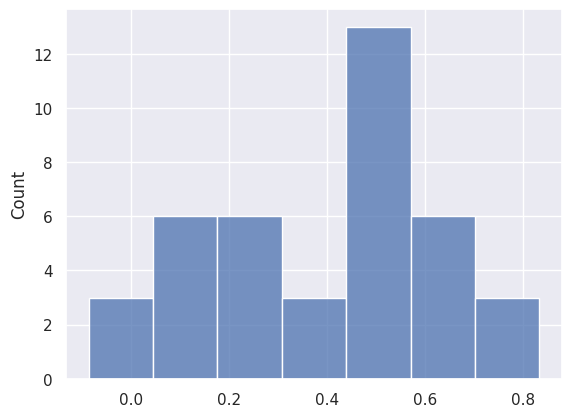

In [ ]:
import seaborn as sns

sns.histplot(sims)

In [ ]:
import numpy as np

threshold = 0.12

ids = [x for x in list(range(len(sims))) if sims[x] >= threshold]
lines_from_save = np.array(lines_from)[ids]
lines_to_save = np.array(lines_to)[ids]

print(f'Saving {len(lines_from_save)} lines with {threshold} threshold.')

assert(len(lines_from_save) == len(lines_to_save))

with open(f'/content/result_{lang_from}_{threshold}.txt', mode='w', encoding='utf-8') as out:
  for x in lines_from_save:
    out.write(x + '\n')

with open(f'/content/result_{lang_to}_{threshold}.txt', mode='w', encoding='utf-8') as out:
  for x in lines_to_save:
    out.write(x + '\n')


Saving 34 lines with 0.12 threshold.
